1. volatility analysis
2. trailing stop back testing


In [3]:
import warnings
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
stock = ['MRVL', 'MSI', 'NOK', 'LRCX', 'SWIR', 'LITE', 'CCI', 'CCOI']
df_hl = pd.DataFrame()
for i in stock:
    df = web.DataReader(i, data_source='yahoo', start='01-01-2020')
    df_hl[i + '-high'] = df['High']
    df_hl[i + '-low'] = df['Low']
    

In [4]:
def daily_vol_rank(stocklist, dataframe_hl=pd.DataFrame(), remove_xtrem_days=2, startdate='01-01-2020'):
    '''
    dataframe_hl = panda datareader from yahoo finance for OHLC data
    remove_xtrem_days = to exclude certain xtrem external one-off events caused large volatility
    '''
    result = {}

    if dataframe_hl.empty:
        df_temp=pd.DataFrame()
        for i in stocklist:    
            df_temp = web.DataReader(i, data_source='yahoo', start=startdate)
            dataframe_hl[i + '-high'] = df_temp['High']
            dataframe_hl[i + '-low'] = df_temp['Low']

    ''' compare stocks' daily volatility by calculating std of (high-low).std and remove extreme volatile days  '''
    for i in stocklist:        
        l = (dataframe_hl[i + '-high'] - dataframe_hl[i + '-low'])/dataframe_hl[i + '-high']
        result[i]=np.std(sorted(l)[:-remove_xtrem_days])
    return result

In [5]:
stock_daily_vol_rank_dict = daily_vol_rank(stock, df_hl, remove_xtrem_days=3).items()
{k: v for k, v in sorted(stock_daily_vol_rank_dict, key=lambda item: item[1], reverse=True)}
# print(stock_daily_vol_rank_dict)

{'SWIR': 0.02692972152810303,
 'CCOI': 0.02058341532631052,
 'LITE': 0.019328588420079652,
 'LRCX': 0.01931387646258975,
 'CCI': 0.017165732778308476,
 'MRVL': 0.016436336966189867,
 'NOK': 0.01572855967479218,
 'MSI': 0.015243516341171999}

In [19]:
l = (df_hl['MSI-high'] - df_hl['MSI-low'])/df_hl['MSI-high']
l[l>0.045].count()
#l.median()
l

Date
2020-01-02    0.009488
2020-01-03    0.031656
2020-01-06    0.023469
2020-01-07    0.008711
2020-01-08    0.011144
                ...   
2020-12-15    0.015219
2020-12-16    0.024106
2020-12-17    0.020717
2020-12-18    0.013565
2020-12-21    0.027591
Length: 246, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

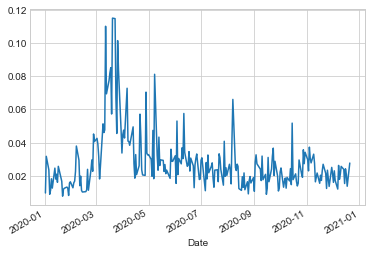

In [20]:
plt.style.use('seaborn-whitegrid')
l.plot()
plt.show

In [12]:
def multi_days_vol_rank(stocklist, dataframe_hl=pd.DataFrame(), remove_xtrem_days=2, hldays=2, startdate='01-01-2020'):
    '''
    dataframe_hl = panda datareader from yahoo finance for OHLC data
    remove_xtrem_days = to exclude certain xtrem external one-off events caused large volatility
    hldays = defines high-low resolution, eg default hldays = 2, highest and lowest price of every 2 days
    '''
    result = {}
    nh = []; nl = []
    if dataframe_hl.empty:
        df_temp=pd.DataFrame()
        for i in stocklist:    
            df_temp = web.DataReader(i, data_source='yahoo', start=startdate)
            dataframe_hl[i + '-high'] = df_temp['High']
            dataframe_hl[i + '-low'] = df_temp['Low']

    ''' compare 2020 stocks' volatility by calculating std of (high-low) across hldays and remove extreme volatile days
    hldays is the high low resolution in days  '''
    
    for i in stocklist:
        for j in range(0, len(dataframe_hl[i + '-high']), hldays):
            nh.append(np.nanmax(dataframe_hl[i + '-high'][j:j+hldays]))
            nl.append(np.nanmin(dataframe_hl[i + '-low'][j:j+hldays]))

        l = np.divide(np.subtract(nh,nl),nh)
        result[i]=np.std(sorted(l)[:-remove_xtrem_days])
        nh = []; nl = []
    return result


In [8]:
m_days_vol_rank = multi_days_vol_rank(stock, df_hl, hldays=5).items()
{k: v for k, v in sorted(m_days_vol_rank, key=lambda item: item[1], reverse=True)}
#print(m_days_vol_rank)

{'SWIR': 0.05682728494449526,
 'NOK': 0.040148490258302985,
 'LRCX': 0.03913077754019284,
 'MRVL': 0.03736009024796287,
 'CCOI': 0.03630992644137195,
 'MSI': 0.03300007180757644,
 'CCI': 0.032652925379588235,
 'LITE': 0.03194776881245283}

In [4]:
print(multi_days_vol_rank(stock, hldays=5))

{'MRVL': 0.03736009024796287, 'MSI': 0.03300007180757644, 'NOK': 0.040148490258302985, 'LRCX': 0.03913077754019284, 'SWIR': 0.05682728494449526, 'LITE': 0.03194776881245283, 'CCI': 0.032652925379588235, 'CCOI': 0.03630992644137195}


In [21]:
nh = []; nl = []

for j in range(0, len(df_hl['NOK-high']), 3):
    nh.append(np.nanmax(df_hl['NOK-high'][j:j+3]))
    nl.append(np.nanmin(df_hl['NOK-high'][j:j+3]))
l = np.divide(np.subtract(nh, nl), nh)
m = sorted(l)
print(m)
print(np.std(m[2:-2]))


[0.0, 0.0, 0.0, 0.002320128115414508, 0.0027855127304566327, 0.003937004178520325, 0.005797095840604812, 0.005905459334988622, 0.006607870754022395, 0.006756803923811303, 0.0069444927352426905, 0.007246312545574519, 0.007335014349416929, 0.007782093947869452, 0.007915559813120093, 0.007984119134284571, 0.00915330958822437, 0.011312260151992382, 0.011876529758149556, 0.011904694325796505, 0.011904694325796505, 0.013186904857471808, 0.013927563652283164, 0.014634132725648943, 0.015075362435176206, 0.015424210688960417, 0.01694919363721445, 0.017031671383796472, 0.01715678826793574, 0.017587922841038908, 0.017676750648606902, 0.017964055186050373, 0.01847573328305803, 0.019999980926513672, 0.02045457969027043, 0.021526444352311918, 0.021582770009893514, 0.02178220383361953, 0.021844582099671467, 0.02233254290380562, 0.022922614179784414, 0.023346281843608353, 0.024752451875445412, 0.024875598285331528, 0.025252561133292602, 0.025345651992388186, 0.025936574474714747, 0.026666641235351562,

In [43]:
abc = [1,2,3]
bcd = [4,5,6]
np.subtract(abc, bcd)

array([-3, -3, -3])

In [29]:
df_hl.loc['20200501']['MRVL-high']

26.3700008392334

In [60]:
transactionDate = df_hl.index
transactionDate[10]

Timestamp('2020-01-16 00:00:00')

In [ ]:
Entry = []; Exit = []
flag = 1 #  1 for buy, -1 for sell
df_hl.loc['20200501':'20200506'][['MSI-low', 'MSI-high']]

for i in df_hl.index:
    print(df_hl.loc[i]['MSI-low'])


In [53]:
 c=len(df_hl['MSI-high'])
    for i in range(len(FullDataFrame['MFI'])):
        if FullDataFrame['MFI'][i] > high:
            buy_signal.append(np.nan)
            sell_signal.append(FullDataFrame['Close'][i])
        elif FullDataFrame['MFI'][i] < low:
            buy_signal.append(FullDataFrame['Close'][i])
            sell_signal.append(np.nan)
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
    return (buy_signal, sell_signal)

In [5]:
# 5% trailing-stop
buy_signal = [np.nan]; sell_signal = [np.nan]
flag = 1 #  1 for buy, -1 for sell
ceiling = 0 
bottom = df_hl['MSI-low'][0]
transactionDate = df_hl.index

for i in range(len(df_hl['MSI-high'])-1):
    if flag == 1:
        bottom = min(bottom, df_hl['MSI-low'][i+1])
        sell_signal.append(np.nan)
        #print(transactionDate[i+1], " bottom = ", bottom, " entry level = ", bottom*1.1)
        if df_hl['MSI-low'][i+1] <= bottom*1.05 < df_hl['MSI-high'][i+1]: # limit order hit the next day
            buy_signal.append(bottom*1.05)
            print(transactionDate[i+1], " buy @ ", bottom*1.05)
            flag = -1
            ceiling = df_hl['MSI-high'][i+1]
        else:
            buy_signal.append(np.nan)
            
    elif flag == -1:
        ceiling = max(ceiling, df_hl['MSI-high'][i+1])
        buy_signal.append(np.nan)
        #print(transactionDate[i+1], " cieling = ",ceiling, " stop loss = ", ceiling/1.1)
        if df_hl['MSI-low'][i+1] <= ceiling/1.05 < df_hl['MSI-high'][i+1]: # stop loss order now hit next day
            sell_signal.append(ceiling/1.05)
            print(transactionDate[i+1], "sell @ ", ceiling/1.05)
            flag = 1
            bottom = df_hl['MSI-low'][i+1]
        else:
            sell_signal.append(np.nan)


2020-01-09 00:00:00  buy @  167.33849487304687
2020-02-25 00:00:00 sell @  178.56190999348956
2020-03-02 00:00:00  buy @  167.74799423217775
2020-03-06 00:00:00 sell @  173.7428501674107
2020-03-09 00:00:00  buy @  170.13149871826172
2020-03-11 00:00:00 sell @  162.65713646298363
2020-03-12 00:00:00  buy @  142.81049423217775
2020-03-13 00:00:00 sell @  147.60952904110863
2020-03-16 00:00:00  buy @  145.39350128173828
2020-03-17 00:00:00 sell @  149.6000017438616
2020-03-18 00:00:00  buy @  143.10449295043946
2020-03-19 00:00:00 sell @  147.43809291294642
2020-03-20 00:00:00  buy @  139.42949295043945
2020-03-26 00:00:00 sell @  142.93333507719493
2020-03-27 00:00:00  buy @  140.25900192260744
2020-04-06 00:00:00 sell @  138.8476126534598
2020-05-04 00:00:00  buy @  138.12750320434571
2020-05-06 00:00:00 sell @  136.63809640066964
2020-05-08 00:00:00  buy @  130.82999839782715
2020-05-11 00:00:00 sell @  129.16190011160714
2020-07-09 00:00:00  buy @  130.57800064086913
2020-07-28 00:00

In [36]:
signals = pd.DataFrame()
signals['Buy'] = buy_signal
signals['Sell'] = sell_signal
i = df_hl.index
signals['date'] = i
signals = signals.set_index('date')

In [1]:
def trailing_stop_signals(df_hl, trailing_pc):
    '''input high low dataframe and trailing percentage eg for 2%, trailing_pc=2)'''
    tpc = trailing_pc/100 + 1
    buy_signal = [np.nan]; sell_signal = [np.nan]
    flag = 1 #  1 for buy, -1 for sell
    ceiling = 0 
    bottom = df_hl['low'][0]
    transactionDate = df_hl.index

    for i in range(len(df_hl['high'])-1):
        if flag == 1:
            bottom = min(bottom, df_hl['low'][i+1])
            sell_signal.append(np.nan)
            #print(transactionDate[i+1], " bottom = ", bottom, " entry level = ", bottom*1.1)
            if df_hl['low'][i+1] <= bottom*tpc < df_hl['high'][i+1]: # limit order hit the next day
                buy_signal.append(bottom*tpc)
                print(transactionDate[i+1], " buy @ ", bottom*tpc)
                flag = -1
                ceiling = df_hl['high'][i+1]
            else:
                buy_signal.append(np.nan)
                
        elif flag == -1:
            ceiling = max(ceiling, df_hl['high'][i+1])
            buy_signal.append(np.nan)
            #print(transactionDate[i+1], " cieling = ",ceiling, " stop loss = ", ceiling/1.1)
            if df_hl['low'][i+1] <= ceiling/tpc < df_hl['high'][i+1]: # stop loss order now hit next day
                sell_signal.append(ceiling/tpc)
                print(transactionDate[i+1], "sell @ ", ceiling/tpc)
                flag = 1
                bottom = df_hl['low'][i+1]
            else:
                sell_signal.append(np.nan)

                
    df_hl['Buy'] = buy_signal
    df_hl['Sell'] = sell_signal
    
    return df_hl

In [2]:
df = web.DataReader('ISRG', data_source='yahoo', start='01-01-2020')
df_hl=pd.DataFrame()
df_hl['high'] = df['High']
df_hl['low'] = df['Low']
df_hl=trailing_stop_signals(df_hl, trailing_pc=3)

NameError: name 'web' is not defined

Back test Profit and Loss

In [91]:
# always 100 shares
(df_hl['Sell'].sum()- df_hl['Buy'].sum())*100

-1150.876463658642